[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/How-to-Learn-to-Code/python-class/blob/master/Lesson_8c_scanpy/Lesson_8c_scanpy.ipynb)

**Note:** This notebook was created largely based off [Preprocessing and clustering 3k PBMCs](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html).
Portions have been removed/edited to adapt to a class time of ~30 minutes.



# [scanpy](https://scanpy.readthedocs.io/en/stable/)

scanpy is a toolkit based in python for single-cell analysis.
Some applications of scanpy include:

* clustering of single-cell data
* trajectory inference (reconstruction of cell pathways)
* differential expression testing (testing differences in gene expression between different cell populations)

# Learning objectives

1. Gain familiarity with single-cell data
2. Experiment with the `adata` object
3. Perform dimension reduction and some clustering analysis of scRNA-seq

Let's first discuss what single-cell data is/looks like...

## single-cell data

There are several types of single-cell data:

* scDNA-seq (genomic single-cell)
* scRNA-seq (transcriptomic single-cell)
* scBS-seq (single-cell bisulfite sequencing)
* ...

These modalities differentiate biological behavior/mechanisms.
In this tutorial, we will be looking at 2700 peripheral blood
mononuclear cells (PBMCs) from a healthy donor.


**What are the benefits of single-cell sequencing over bulk sequencing?**

Knowing the sequencing profiles of single-cells adds granularity to data obtained from samples that may contain more than one type of cell.
For instance, knowing the transcriptomic profiles of single cells in a population of heterogeneous tumor cells can reveal insights into tumorigenesis. Researchers may be able to investigate novel biological activity as stem cells abnormally mature into cancerous cells.

**How is single-cell data created?**

There are various methods depending on the application and type of single-cell
data.
However, I hope the image ([Chan Zuckerberg Initiative](https://chanzuckerberg.github.io/scRNA-python-workshop/intro/overview.html)) below captures how single-cell data is created.
In short, single cells are isolated from tissue, sequenced and amplified.

![scRNA-seq workflow](./images/figure_1_scrnaseq_workflow.png)

Now that we know how single-cell data is generated, let's talk about how single-cell data is represented in scanpy.


In [ ]:
# install these packages first
# install the anndata library
!pip install anndata
# install the scanpy library
!pip install scanpy
!pip install leidenalg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 6.8 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82813 sha256=d621e93e424f222cf64e049770dc68c73ebfec399f317778321e149dd0c7824f
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=9397315748180130ebfce6f3d344da6b1d84b55c7fb8765365998deddbbb0b09
  Stored in directory: /root/.cache/pip/wheels/6a/aa/

In [ ]:
# import necessary libraries
import numpy as np
import pandas as pd
import anndata as ad
from scipy.sparse import csr_matrix
import scanpy as sc

<a name="anndata"></a>
## [AnnData](https://anndata.readthedocs.io/en/latest/index.html)

The anndata python package enables the use of anndata objects which are essentially annotated data matrices.

The following (taken from [Getting started with anndata](https://anndata.readthedocs.io/en/latest/tutorials/notebooks/getting-started.html)) demonstrates some of the features of the anndata object.



In [ ]:
# first, create a matrix of 100 (cells) x 2000 (genes)
counts = csr_matrix(np.random.poisson(1, size=(100, 2000)), dtype=np.float32)
adata = ad.AnnData(counts)
# create index names...observation names and variable names
adata.obs_names = [f"Cell_{i:d}" for i in range(adata.n_obs)]
adata.var_names = [f"Gene_{i:d}" for i in range(adata.n_vars)]
print(adata.obs_names[:10])

Index(['Cell_0', 'Cell_1', 'Cell_2', 'Cell_3', 'Cell_4', 'Cell_5', 'Cell_6',
       'Cell_7', 'Cell_8', 'Cell_9'],
      dtype='object')


After running the code above, the `adata` object created has a data matrix `X` attribute which essentially looks like the below:


![adata object](./images/figure_2_adata_object.png)


This can also be observed in python by running the below which converts the aData object into a dataframe using `to_df`.

In [ ]:
# outputs a dataframe version of the X matrix
adata.to_df()

,Gene_0,Gene_1,Gene_2,Gene_3,Gene_4,Gene_5,Gene_6,Gene_7,Gene_8,Gene_9,...,Gene_1990,Gene_1991,Gene_1992,Gene_1993,Gene_1994,Gene_1995,Gene_1996,Gene_1997,Gene_1998,Gene_1999
Cell_0,2.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,1.0,2.0,...,0.0,1.0,1.0,0.0,1.0,2.0,1.0,1.0,1.0,3.0
Cell_1,0.0,4.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,2.0,3.0,0.0,1.0,1.0,1.0,3.0,2.0,1.0,1.0
Cell_2,0.0,0.0,2.0,1.0,0.0,0.0,1.0,2.0,0.0,1.0,...,1.0,2.0,0.0,1.0,0.0,2.0,3.0,1.0,2.0,1.0
Cell_3,2.0,1.0,1.0,2.0,1.0,0.0,1.0,2.0,1.0,0.0,...,2.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,3.0,0.0
Cell_4,1.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cell_95,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,3.0
Cell_96,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,2.0,...,1.0,0.0,1.0,1.0,0.0,2.0,0.0,1.0,1.0,0.0
Cell_97,1.0,0.0,4.0,2.0,1.0,0.0,2.0,0.0,1.0,1.0,...,3.0,3.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0
Cell_98,3.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,2.0,1.0,...,0.0,1.0,0.0,4.0,1.0,0.0,1.0,0.0,3.0,2.0




Now, let's add in some annotations/metadata at the observation level.
This could be the cell type of each observation.

In [ ]:
# random cell assignment
ct = np.random.choice(["B", "T", "Monocyte"], size=(adata.n_obs,))
adata.obs["cell_type"] = pd.Categorical(ct)  # Categoricals are preferred for efficiency
adata.obs

,cell_type
Cell_0,B
Cell_1,B
Cell_2,B
Cell_3,Monocyte
Cell_4,Monocyte
...,...
Cell_95,B
Cell_96,B
Cell_97,B
Cell_98,T


For metadata that has many dimensions (each cell could have a 2-dim UMAP mapping or each gene could have a 5-dim feature set), we can use the `obsm` and `varm` attributes as shown below.

In [ ]:
# add n-dim metadata to variables
adata.obsm["X_umap"] = np.random.normal(0, 1, size=(adata.n_obs, 2))
adata.varm["gene_stuff"] = np.random.normal(0, 1, size=(adata.n_vars, 5))

The above is a very brief overview of the anndata object.
For more information, see [Getting started with anndata](https://anndata.readthedocs.io/en/latest/tutorials/notebooks/getting-started.html).

Let's move on to some of the functions of scanpy.

<a name="scanpy-demo"></a>
# scanpy demo

First, let's download and read in the demo 3k PBMC scRNA-seq data from [10X Genomics](https://www.10xgenomics.com/) (company that provides services single-cell data generation and analysis).

In [ ]:
# fetch the scanpy demo data
!mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

# read in the data
# place cursor after first parantheses and push ctrl/cmd+shift+space bar to bring up docstrings
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

--2023-07-31 16:15:40--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [following]
--2023-07-31 16:15:41--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

data/pbmc3k_filtere 100%[===================>]   7.27M  --.-KB/s    in 0.07s   

2023-07-31 16:15:41 (97.9 MB/s) - ‘data/pbmc3k_filtered_gene_bc_matri

## scanpy - explore and filter data
Let's first look at the most highly expressed 20 genes in our dataset:


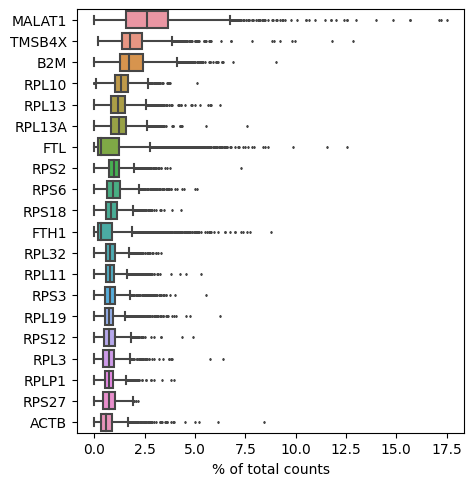

2700
32738


In [ ]:
sc.pl.highest_expr_genes(adata, n_top=20, )
# return the number of observations
print(adata.n_obs)
# return the number of variables
print(adata.n_vars)

Now, let's do some filtering for gene and cell representation.

In [ ]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
# return the number of observations
print(adata.n_obs)
# return the number of variables
print(adata.n_vars)
# looks like no cells were removed and 19,024 genes were removed
# add some zeros if expression below a certain level
# adata.X[adata.X < 0.3] = 0

2700
13714


For brevity, the steps below filter out cells of poor quality (containing high proportions of mitochondrial genes) and also perform some normalization.
See [Preprocessing and clustering 3k PBMCs](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) for more details.
In the next section we will look at principle components and do some clustering to see if we can group cells with similar expression profiles.

In [ ]:
# filter out poor quality cells
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

# normalization
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata

# filter out highly variable genes
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


## scanpy - PCA and UMAP clustering

PCA stands for principle component analysis.
Principle components (PCs) are axes capturing variation in your data.
They are often used to reduce the dimensionality of your dataset and can be used in machine learning/regression models.
See [A Step-By-Step Introduction to PCA](https://towardsdatascience.com/a-step-by-step-introduction-to-pca-c0d78e26a0dd) for a more detailed overview.
Let's calculate the PCs and visualize the first two PCs highlighting CST3 expression.


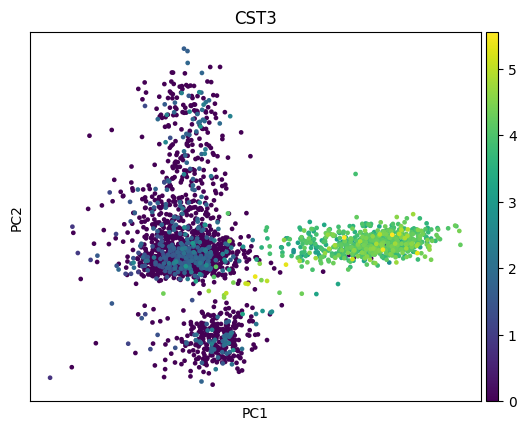

In [ ]:
# look at pcs to see how many pcs to use in neighborhood graph construction
sc.tl.pca(adata, svd_solver='arpack')
# pl ie plot just the first two principle components
sc.pl.pca(adata, color='CST3')

In the figure above, each dot is a cell plotted against the first two PCs.
The color of the dot is correlated with CST3 expression.
It looks like there are three or four different clusters just based on these PCs and CST3 expression level.

Now, let's create an elbow plot which will plot variance captured vs each PC.
This gives us an idea of which PCs to use in clustering (those that capture the most variance).

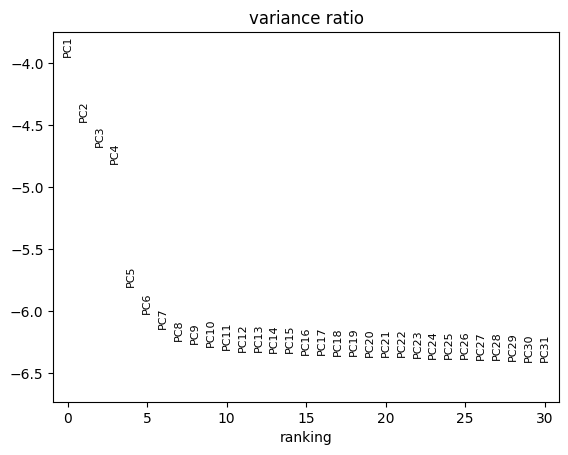

In [ ]:
# note that this is a logarithmic scale of variance ratio
sc.pl.pca_variance_ratio(adata, log=True)

In order to perform clustering, we need to compute the neighborhood graph using and embed the graph in UMAP (Uniform Manifold Approximation and Projection) dimensions.
Neighborhood graphs are first determined where nodes represent cells and lines indicate degrees of similarity between cells ie lines with greater weight indicate cells are more closely similar to each other.

![graph example](./images/figure_3_graph.png)

Knowing this, we then embed the graph in UMAP dimensions.
UMAP is another dimension reduction technique but is based on the idea that most high dimensional data lies in manifolds.
We won't go into much detail here regarding UMAP, but the below links are helpful to learn more:

* [How UMAP Works](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html)
* [Dimensionality Reduction for Data Visualization: PCA vs TSNE vs UMAP vs LDA](https://towardsdatascience.com/dimensionality-reduction-for-data-visualization-pca-vs-tsne-vs-umap-be4aa7b1cb29)
* [McInnes et al. (2018)](https://joss.theoj.org/papers/10.21105/joss.00861)


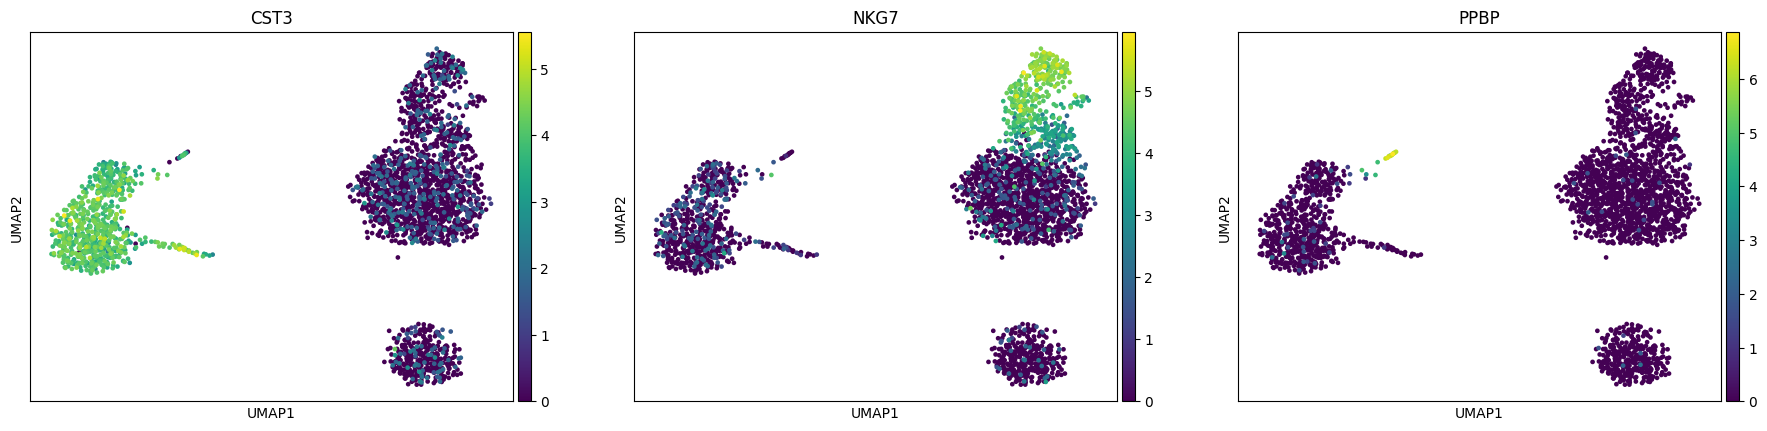

In [ ]:
# calculate neighborhood graph pp = preprocessing using the first 40 PCs
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# initial clustering...this part isn't in the official demo but I think they forgot this part
sc.tl.leiden(adata)
# remedy disconnected clusters...
sc.tl.paga(adata) # maps "coarse-grained connectivity structures of complex manifolds", tl = toolkit, paga = partition-based graph abstraction
sc.pl.paga(adata, plot=False)  # compute the course grained layout, pl = plot
sc.tl.umap(adata, init_pos='paga') # embed in umap

# embedding of neighborhood graph using UMAP
sc.tl.umap(adata)
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

Now, we can finally cluster the data using the Leiden graph-clustering method, which tries to detect communities of nodes.

Again, we won't go into too much detail regarding this methods, but the below are helpful:

* [Community Detection Algorithms
](https://towardsdatascience.com/community-detection-algorithms-9bd8951e7dae)
* [Traag et al. (2018)](https://www.nature.com/articles/s41598-019-41695-z)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


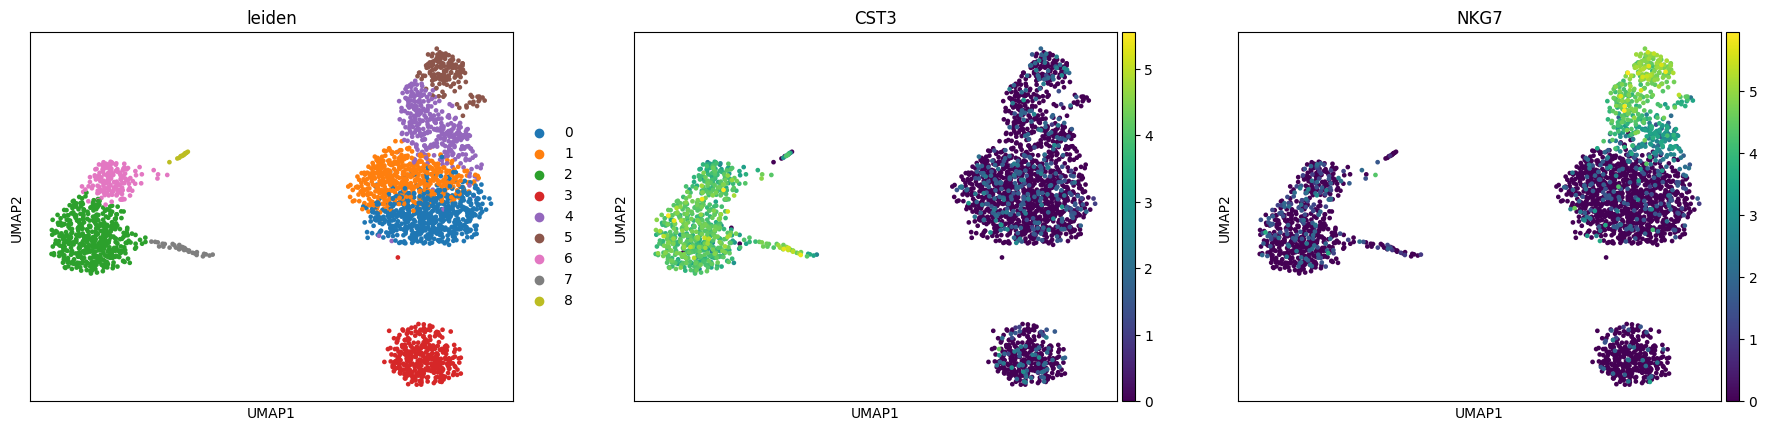

In [ ]:
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])


## In-class exercises

In-class exercise 1: From the [AnnData](#anndata) section...instead of creating a `csr_matrix` can we create a pandas dataframe instead to look at the data more easily?

Answer:



In [ ]:
pd.DataFrame(np.random.poisson(1, size=(100, 2000)))




In-class exercise 2: Find the UMAP mappings for cell 5 in the `adata` object.

Answer:


In [ ]:
adata.obsm["X_umap"][4]